Zhenhao Yu 4295788

In [1]:
pip install photutils

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install batman-package

Note: you may need to restart the kernel to use updated packages.


C:\Users\yuzhe\AppData\Local\Temp\ipykernel_37588\2085716490.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_37588\2085716490.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_37588\2085716490.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, ple

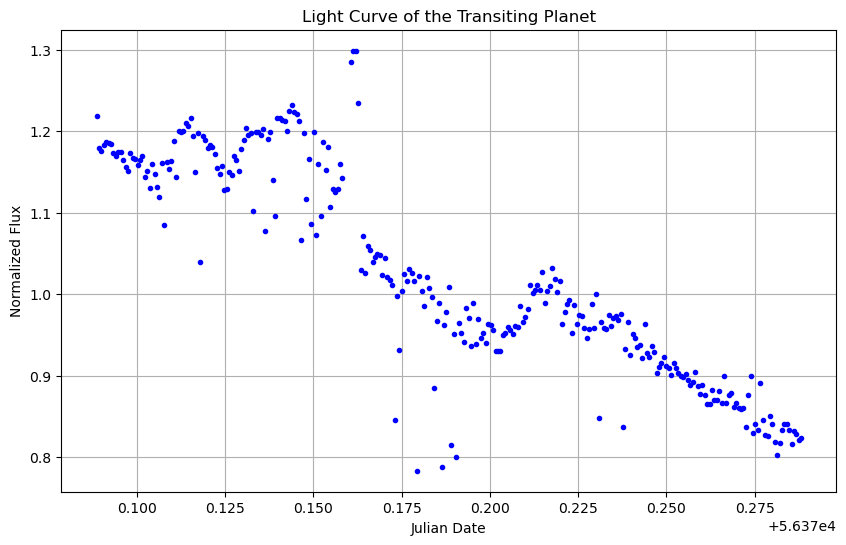

In [9]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

# List of numbers to skip (specific files to exclude)
skip_numbers = [70, 183]

# Generate the list of FITS files, skipping specific files
imagefiles = [f'/Users/yuzhe/OneDrive/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits' for num in range(80, 370) if num not in skip_numbers]
timestamps = []
fluxes = []

for filename in imagefiles:
    with fits.open(filename) as hdul:
        image = hdul[0].data  # Extract the image data
        header = hdul[0].header  # Extract the header data

        # Extract timestamp, assuming JD is stored in the header
        timestamp = header.get('MJD-OBS', None)  # Replace 'JD' with the actual keyword
        timestamps.append(timestamp)

        # Calculate statistics for background subtraction
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)

        # Use DAOStarFinder to locate stars
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  # Adjust FWHM to match your star size
        sources = daofind(image - median)
        if sources is None or len(sources) == 0:
            continue  # Skip this image if no stars found

        # Find the closest source to the expected position
        expected_position = np.array([1005, 1046])
        positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
        distances = np.sqrt(np.sum((positions - expected_position)**2, axis=1))
        target_star = positions[np.argmin(distances)]

        # Define the aperture at the detected position
        aperture = CircularAperture(target_star, r=10)
        phot_table = aperture_photometry(image - median, aperture)

        # Append total brightness within the aperture to the fluxes list
        total_brightness = phot_table['aperture_sum'][0]
        fluxes.append(total_brightness)

# Normalize the flux
median_flux = np.median(fluxes)
normalized_flux = fluxes / median_flux

# Plotting the light curve
plt.figure(figsize=(10, 6))
plt.plot(timestamps, normalized_flux, '.', color='blue')
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')
plt.title('Light Curve of the Transiting Planet')
plt.grid(True)
plt.show()

It appears that the planet is transiting in front of the star around 0.16 to 0.21 at the Julian axis. The reason that the light curve is going down is mostly due to the telescope is out of focus. We can visually compare the first and last image, and the last image's focus point is way off the first one. Despite the fact the light curve is going down, we can clearly see an abrupt dent at the center of the graph.

C:\Users\yuzhe\AppData\Local\Temp\ipykernel_34736\2934808851.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_34736\2934808851.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_34736\2934808851.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, ple

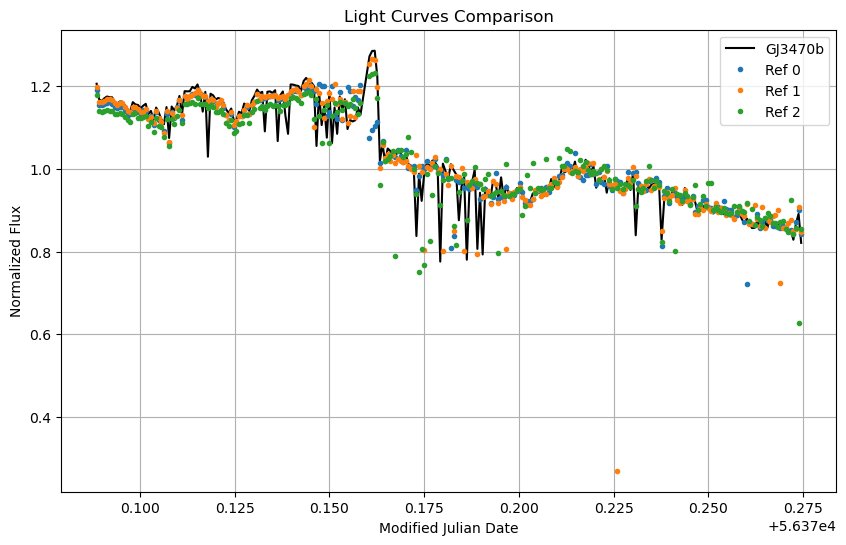

In [14]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

# Define expected positions of calibration stars and the target star
expected_positions = [
    np.array([772, 750]),
    np.array([1354, 87]),
    np.array([1151, 1910]),
    np.array([1005, 1046])  # Target star position added as the last element
]
# List of numbers to skip (specific files to exclude)
skip_numbers = [70, 183]

# Generate the list of FITS files, skipping specific files
imagefiles = [
    f'/Users/yuzhe/OneDrive/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
    for num in range(80, 350) if num not in skip_numbers
]

# Initialize lists for timestamps and flux data for each calibration star including the target
timestamps = []
flux_data = {pos: [] for pos in range(len(expected_positions))}

for filename in imagefiles:
    with fits.open(filename) as hdul:
        image = hdul[0].data
        header = hdul[0].header
        timestamp = header.get('MJD-OBS', None)
        timestamps.append(timestamp)
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
        sources = daofind(image - median)

        if sources is None or len(sources) == 0:
            continue

        for idx, exp_pos in enumerate(expected_positions):
            positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
            distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
            closest = positions[np.argmin(distances)]
            aperture = CircularAperture(closest, r=10)
            phot_table = aperture_photometry(image - median, aperture)
            flux_data[idx].append(phot_table['aperture_sum'][0])

# Normalize the fluxes
normalized_fluxes = {}
for idx, fluxes in flux_data.items():
    median_flux = np.median(fluxes)
    normalized_fluxes[idx] = np.array(fluxes) / median_flux

# Calculate the mean reference curve by averaging normalized curves of references
mean_reference_flux = np.mean([flux for idx, flux in normalized_fluxes.items() if idx != 4], axis=0)  # Exclude target
std_deviations = list(reference_quality.values())
average_std = np.mean(std_deviations)
std_of_std = np.std(std_deviations)
some_threshold = average_std + 2 * std_of_std

# Assessing quality of reference light curves by comparing to target
target_flux = normalized_fluxes[3]  # Target star is at index 3
reference_quality = {idx: np.std(target_flux - flux) for idx, flux in normalized_fluxes.items() if idx != 3}
good_references = [idx for idx, quality in reference_quality.items() if quality < some_threshold]

# Plotting target and good reference light curves
plt.figure(figsize=(10, 6))
plt.plot(timestamps, target_flux, 'k-', label='GJ3470b')
for idx in good_references:
    plt.plot(timestamps, normalized_fluxes[idx], '.', label=f'Ref {idx}')
plt.xlabel('Modified Julian Date')
plt.ylabel('Normalized Flux')
plt.title('Light Curves Comparison')
plt.grid(True)
plt.legend()
plt.show()



C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\242657578.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\242657578.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\242657578.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please

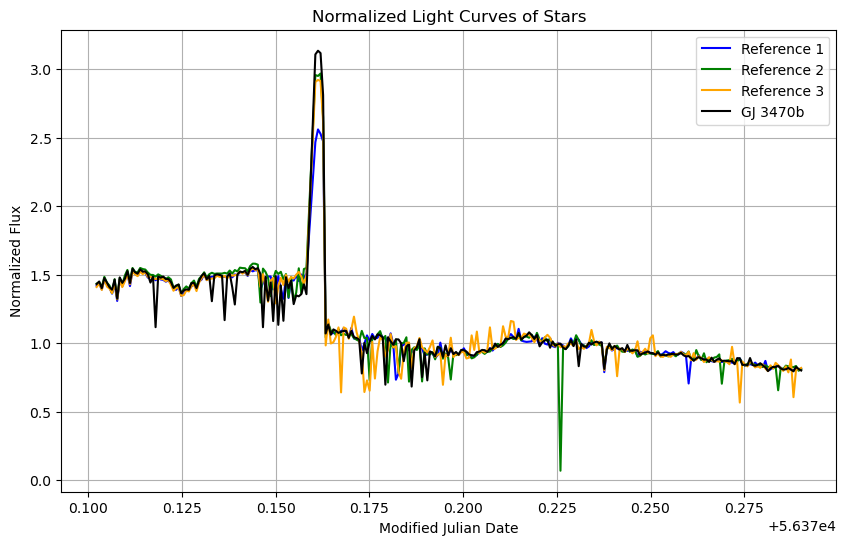

In [8]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

def load_fits_files(file_range, skip_numbers):
    """Generates a list of FITS file paths to be processed."""
    return [
        f'/Users/yuzhe/OneDrive/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
        for num in file_range if num not in skip_numbers
    ]

def extract_photometry(imagefiles, expected_positions, aperture_radius):
    """Extract photometry data from FITS files for given star positions."""
    timestamps = []
    flux_data = {idx: [] for idx in range(len(expected_positions))}

    for filename in imagefiles:
        with fits.open(filename) as hdul:
            image = hdul[0].data
            header = hdul[0].header
            timestamps.append(header.get('MJD-OBS'))
            mean, median, std = sigma_clipped_stats(image, sigma=3.0)
            daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
            sources = daofind(image - median)
            
            if sources is None or len(sources) == 0:
                continue

            for idx, exp_pos in enumerate(expected_positions):
                positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
                distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
                closest = positions[np.argmin(distances)]
                aperture = CircularAperture(closest, r=aperture_radius)
                phot_table = aperture_photometry(image - median, aperture)
                flux_data[idx].append(phot_table['aperture_sum'][0])

    return timestamps, flux_data

def normalize_fluxes(flux_data):
    """Normalize the flux data."""
    normalized_fluxes = {}
    for idx, fluxes in flux_data.items():
        median_flux = np.median(fluxes)
        normalized_fluxes[idx] = np.array(fluxes) / median_flux
    return normalized_fluxes

def plot_light_curves(timestamps, normalized_fluxes):
    """Plot multiple light curves on one graph."""
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'green', 'orange', 'black']  # colors for each star, last one is for target
    labels = ['Reference 1', 'Reference 2', 'Reference 3', 'GJ 3470b']

    for idx, (flux, color, label) in enumerate(zip(normalized_fluxes.values(), colors, labels)):
        plt.plot(timestamps, flux, '-', color=color, label=label)

    plt.xlabel('Modified Julian Date')
    plt.ylabel('Normalized Flux')
    plt.title('Normalized Light Curves of Stars')
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    skip_numbers = [70, 183]
    expected_positions = [
        np.array([772, 750]),
        np.array([1354, 87]),
        np.array([1151, 1910]),
        np.array([1005, 1046])  # Assuming the last entry is the target star
    ]
    aperture_radius = 5  # Adjusted for typical star sizes
    file_range = range(100, 373)
    imagefiles = load_fits_files(file_range, skip_numbers)
    timestamps, flux_data = extract_photometry(imagefiles, expected_positions, aperture_radius)
    normalized_fluxes = normalize_fluxes(flux_data)
    
    plot_light_curves(timestamps, normalized_fluxes)

if __name__ == "__main__":
    main()


----------------------------------

C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\350303008.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\350303008.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_55176\350303008.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please

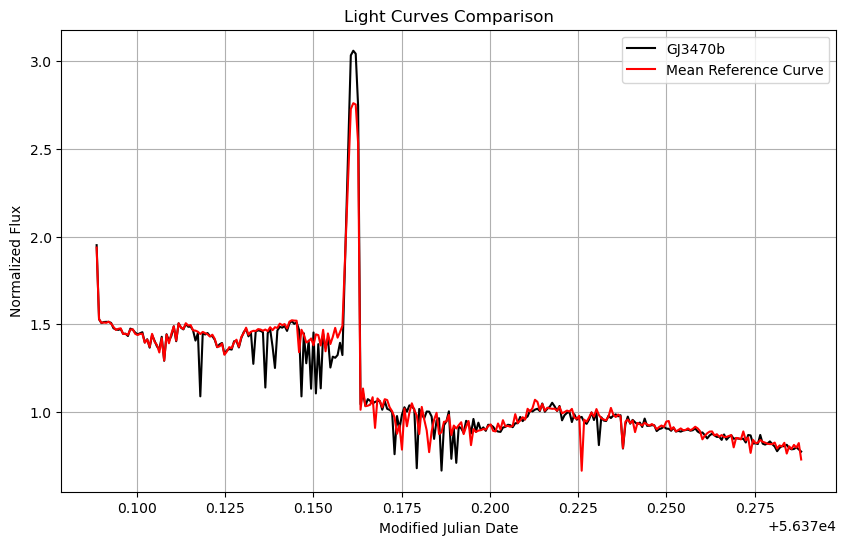

In [12]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

# Define expected positions of calibration stars and the target star
expected_positions = [
    np.array([772, 750]),
    np.array([1354, 87]),
    np.array([1151, 1910]),
    np.array([1005, 1046])  # Target star position added as the last element
]

# List of numbers to skip (specific files to exclude)
skip_numbers = [70, 183]

# Generate the list of FITS files, skipping specific files
imagefiles = [
    f'/Users/yuzhe/OneDrive/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
    for num in range(80, 370) if num not in skip_numbers
]

# Initialize lists for timestamps and flux data for each calibration star including the target
timestamps = []
flux_data = {pos: [] for pos in range(len(expected_positions))}

for filename in imagefiles:
    with fits.open(filename) as hdul:
        image = hdul[0].data
        header = hdul[0].header
        timestamp = header.get('MJD-OBS', None)
        timestamps.append(timestamp)
        mean, median, std = sigma_clipped_stats(image, sigma=3.0)
        daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
        sources = daofind(image - median)

        if sources is None or len(sources) == 0:
            continue

        for idx, exp_pos in enumerate(expected_positions):
            positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
            distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
            closest = positions[np.argmin(distances)]
            aperture = CircularAperture(closest, r=5)
            phot_table = aperture_photometry(image - median, aperture)
            flux_data[idx].append(phot_table['aperture_sum'][0])

# Normalize the fluxes
normalized_fluxes = {}
for idx, fluxes in flux_data.items():
    median_flux = np.median(fluxes)
    normalized_fluxes[idx] = np.array(fluxes) / median_flux

# Assuming target is the last star, calculate reference quality comparing to target
target_flux = normalized_fluxes[3]  # Target star is at index 3
reference_quality = {idx: np.std(target_flux - flux) for idx, flux in normalized_fluxes.items() if idx != 3}

# Calculate statistics to determine some_threshold
std_deviations = list(reference_quality.values())
average_std = np.mean(std_deviations)
std_of_std = np.std(std_deviations)
some_threshold = average_std + 2 * std_of_std

# Discard poorly matched light curves by comparing to target using some metric
good_references = [idx for idx, quality in reference_quality.items() if quality < some_threshold]

# Calculate the mean reference curve by averaging normalized curves of good references
mean_reference_flux = np.mean([normalized_fluxes[idx] for idx in good_references], axis=0)

# Plotting target and good reference light curves
plt.figure(figsize=(10, 6))
plt.plot(timestamps, target_flux, 'k-', label='GJ3470b')
plt.plot(timestamps, mean_reference_flux, 'r-', label='Mean Reference Curve')
plt.xlabel('Modified Julian Date')
plt.ylabel('Normalized Flux')
plt.title('Light Curves Comparison')
plt.grid(True)
plt.legend()
plt.show()


C:\Users\yuzhe\AppData\Local\Temp\ipykernel_47700\3627060745.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_47700\3627060745.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
C:\Users\yuzhe\AppData\Local\Temp\ipykernel_47700\3627060745.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, ple

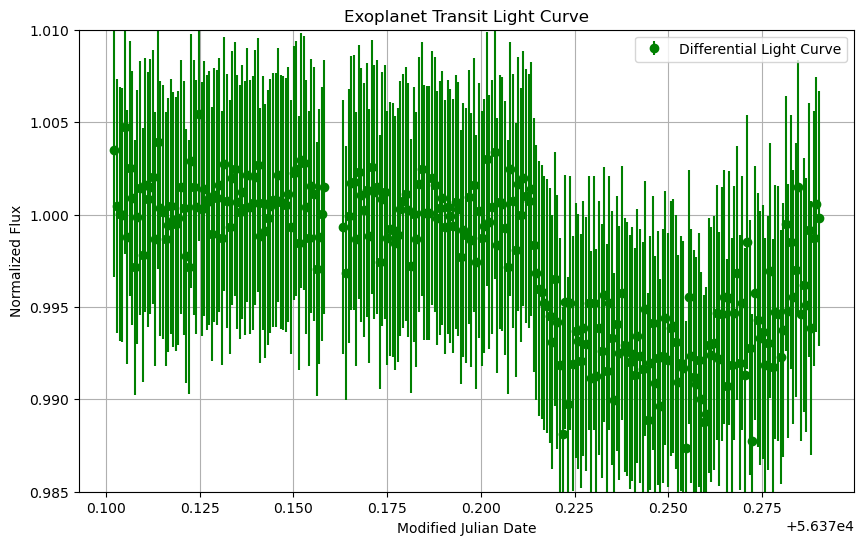

In [1]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt

def load_fits_files(file_range, skip_numbers):
    """Generates a list of FITS file paths to be processed."""
    return [
        f'/Users/yuzhe/OneDrive/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
        for num in file_range if num not in skip_numbers
    ]

def extract_photometry(imagefiles, expected_positions, aperture_radius):
    """Extract photometry data from FITS files for given star positions."""
    timestamps = []
    flux_data = {idx: [] for idx in range(len(expected_positions))}

    for filename in imagefiles:
        with fits.open(filename) as hdul:
            image = hdul[0].data
            header = hdul[0].header
            timestamps.append(header.get('MJD-OBS'))
            mean, median, std = sigma_clipped_stats(image, sigma=3.0)
            daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
            sources = daofind(image - median)
            
            if sources is None or len(sources) == 0:
                continue

            for idx, exp_pos in enumerate(expected_positions):
                positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
                distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
                closest = positions[np.argmin(distances)]
                aperture = CircularAperture(closest, r=aperture_radius)
                phot_table = aperture_photometry(image - median, aperture)
                flux_data[idx].append(phot_table['aperture_sum'][0])

    return timestamps, flux_data

def normalize_fluxes(flux_data):
    """Normalize the flux data."""
    normalized_fluxes = {}
    for idx, fluxes in flux_data.items():
        median_flux = np.median(fluxes)
        normalized_fluxes[idx] = np.array(fluxes) / median_flux
    return normalized_fluxes

def plot_light_curve(timestamps, differential_flux):
    """Plot the light curve with error bars."""
    error_estimate = np.std(differential_flux)
    plt.figure(figsize=(10, 6))
    plt.errorbar(timestamps, differential_flux, yerr=error_estimate, fmt='o', color='g', label='GJ 3470b data')
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Normalized Flux')
    plt.title('Exoplanet Transit Light Curve')
    plt.ylim(0.985, 1.01)
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    skip_numbers = [70, 183]
    expected_positions = [
        np.array([772, 750]),
        np.array([1354, 87]),
        np.array([1151, 1910]),
        np.array([1005, 1046])  # Assuming the last entry is the target star
    ]
    aperture_radius = 30
    file_range = range(100, 373)
    imagefiles = load_fits_files(file_range, skip_numbers)
    timestamps, flux_data = extract_photometry(imagefiles, expected_positions, aperture_radius)
    normalized_fluxes = normalize_fluxes(flux_data)
    
    # Assuming the last position is the target and the rest are references
    mean_reference_flux = np.mean([flux for idx, flux in normalized_fluxes.items() if idx != len(expected_positions)-1], axis=0)
    target_flux = normalized_fluxes[len(expected_positions)-1]
    differential_flux = target_flux / mean_reference_flux
    
    plot_light_curve(timestamps, differential_flux)

if __name__ == "__main__":
    main()


/Users/yuzhenhao/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/var/folders/gp/hwk4gr811bs1fb9zvynbkg0w0000gn/T/ipykernel_2782/463542147.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
/var/folders/gp/hwk4gr811bs1fb9zvynbkg0w0000gn/T/ipykernel_2782/463542147.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutil

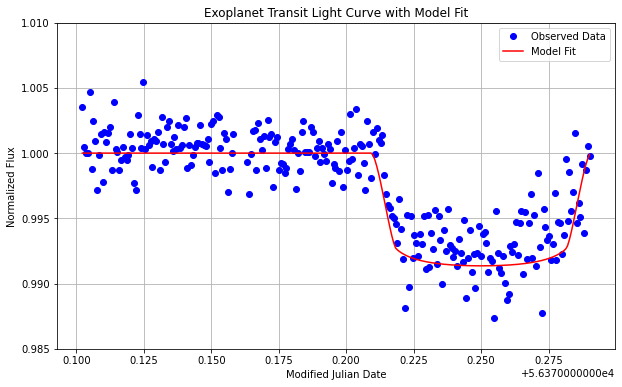

In [3]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt
import batman

def load_fits_files(file_range, skip_numbers):
    """Generates a list of FITS file paths to be processed."""
    return [
        f'/Users/yuzhenhao/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
        for num in file_range if num not in skip_numbers
    ]

def extract_photometry(imagefiles, expected_positions, aperture_radius):
    """Extract photometry data from FITS files for given star positions."""
    timestamps = []
    flux_data = {idx: [] for idx in range(len(expected_positions))}

    for filename in imagefiles:
        with fits.open(filename) as hdul:
            image = hdul[0].data
            header = hdul[0].header
            timestamps.append(header.get('MJD-OBS'))
            mean, median, std = sigma_clipped_stats(image, sigma=3.0)
            daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
            sources = daofind(image - median)
            
            if sources is None or len(sources) == 0:
                continue

            for idx, exp_pos in enumerate(expected_positions):
                positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
                distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
                closest = positions[np.argmin(distances)]
                aperture = CircularAperture(closest, r=aperture_radius)
                phot_table = aperture_photometry(image - median, aperture)
                flux_data[idx].append(phot_table['aperture_sum'][0])

    return timestamps, flux_data

def normalize_fluxes(flux_data):
    """Normalize the flux data."""
    normalized_fluxes = {}
    for idx, fluxes in flux_data.items():
        median_flux = np.median(fluxes)
        normalized_fluxes[idx] = np.array(fluxes) / median_flux
    return normalized_fluxes

def plot_light_curve(timestamps, differential_flux):
    """Plot the light curve with a batman model fit."""
    params = batman.TransitParams()
    params.t0 = 0.25+56370  # time of inferior conjunction; mid-transit time
    params.per = 4.0  # orbital period
    params.rp = 0.09# planet radius (in units of stellar radii)
    params.a = 15.0  # semi-major axis (in units of stellar radii)
    params.inc = 88.0  # orbital inclination (in degrees)
    params.ecc = 0.0  # eccentricity
    params.w = 90.0  # longitude of periastron (in degrees)
    params.limb_dark = "quadratic"  # limb darkening model
    params.u = [0.1, 0.3]  # limb darkening coefficients
    
    timestamps = np.array(timestamps)     # Convert timestamps to numpy array
    m = batman.TransitModel(params, timestamps)    # Initialize the model
    model_flux = m.light_curve(params)             # Calculate model light curve

    plt.figure(figsize=(10, 6))
    plt.plot(timestamps, differential_flux, 'o', color='blue', label='Observed Data')
    plt.plot(timestamps, model_flux, color='red', label='Model Fit')
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Normalized Flux')
    plt.title('Exoplanet Transit Light Curve with Model Fit')
    plt.ylim(0.985, 1.01)
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    skip_numbers = [70, 183]
    expected_positions = [
        np.array([772, 750]),
        np.array([1354, 87]),
        np.array([1151, 1910]),
        np.array([1005, 1046])  # Assuming the last entry is the target star
    ]
    aperture_radius = 30
    file_range = range(100, 373)
    imagefiles = load_fits_files(file_range, skip_numbers)
    timestamps, flux_data = extract_photometry(imagefiles, expected_positions, aperture_radius)
    normalized_fluxes = normalize_fluxes(flux_data)
    
    # Assuming the last position is the target and the rest are references
    mean_reference_flux = np.mean([flux for idx, flux in normalized_fluxes.items() if idx != len(expected_positions)-1], axis=0)
    target_flux = normalized_fluxes[len(expected_positions)-1]
    differential_flux = target_flux / mean_reference_flux
    
    plot_light_curve(timestamps, differential_flux)

if __name__ == "__main__":
    main()


/var/folders/gp/hwk4gr811bs1fb9zvynbkg0w0000gn/T/ipykernel_2782/1801753761.py:4: DeprecationWarning: `photutils.DAOStarFinder` is a deprecated alias for `photutils.detection.DAOStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import DAOStarFinder` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
/var/folders/gp/hwk4gr811bs1fb9zvynbkg0w0000gn/T/ipykernel_2782/1801753761.py:4: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import DAOStarFinder, CircularAperture, aperture_photometry
/var/folders/gp/hwk4gr811bs1fb9zvynbkg0w0000gn/T/ipykernel_2782/1801753761.py:4: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and w

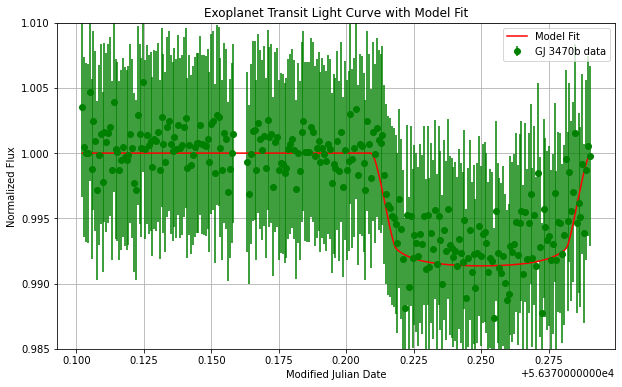

In [5]:
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder, CircularAperture, aperture_photometry
import matplotlib.pyplot as plt
import batman

def load_fits_files(file_range, skip_numbers):
    """Generates a list of FITS file paths to be processed."""
    return [
        f'/Users/yuzhenhao/Desktop/GJ3470b/elp1m008-kb74-20130318-{num:04d}-e90.fits'
        for num in file_range if num not in skip_numbers
    ]

def extract_photometry(imagefiles, expected_positions, aperture_radius):
    """Extract photometry data from FITS files for given star positions."""
    timestamps = []
    flux_data = {idx: [] for idx in range(len(expected_positions))}

    for filename in imagefiles:
        with fits.open(filename) as hdul:
            image = hdul[0].data
            header = hdul[0].header
            timestamps.append(header.get('MJD-OBS'))
            mean, median, std = sigma_clipped_stats(image, sigma=3.0)
            daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)
            sources = daofind(image - median)
            
            if sources is None or len(sources) == 0:
                continue

            for idx, exp_pos in enumerate(expected_positions):
                positions = np.array([sources['xcentroid'], sources['ycentroid']]).T
                distances = np.sqrt(np.sum((positions - exp_pos)**2, axis=1))
                closest = positions[np.argmin(distances)]
                aperture = CircularAperture(closest, r=aperture_radius)
                phot_table = aperture_photometry(image - median, aperture)
                flux_data[idx].append(phot_table['aperture_sum'][0])

    return timestamps, flux_data

def normalize_fluxes(flux_data):
    """Normalize the flux data."""
    normalized_fluxes = {}
    for idx, fluxes in flux_data.items():
        median_flux = np.median(fluxes)
        normalized_fluxes[idx] = np.array(fluxes) / median_flux
    return normalized_fluxes

def plot_light_curve(timestamps, differential_flux):
    """Plot the light curve with a batman model fit and error bars."""
    params = batman.TransitParams()       # Create a TransitParams object
    params.t0 = 0.25 + 56370              # Time of inferior conjunction; mid-transit time
    params.per = 4.0                      # Orbital period
    params.rp = 0.09                      # Planet radius (in units of stellar radii)
    params.a = 15.0                       # Semi-major axis (in units of stellar radii)
    params.inc = 88.0                     # Orbital inclination (in degrees)
    params.ecc = 0.0                      # Eccentricity
    params.w = 90.0                       # Longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        # Limb darkening model
    params.u = [0.1, 0.3]                 # Limb darkening coefficients

    timestamps = np.array(timestamps)     # Convert timestamps to numpy array
    m = batman.TransitModel(params, timestamps)    # Initialize the model
    model_flux = m.light_curve(params)             # Calculate model light curve

    error_estimate = np.std(differential_flux)
    plt.figure(figsize=(10, 6))
    plt.errorbar(timestamps, differential_flux, yerr=error_estimate, fmt='o', color='g', label='GJ 3470b data')
    plt.plot(timestamps, model_flux, color='r', label='Model Fit')
    plt.xlabel('Modified Julian Date')
    plt.ylabel('Normalized Flux')
    plt.title('Exoplanet Transit Light Curve with Model Fit')
    plt.ylim(0.985, 1.01)
    plt.grid(True)
    plt.legend()
    plt.show()

def main():
    skip_numbers = [70, 183]
    expected_positions = [
        np.array([772, 750]),
        np.array([1354, 87]),
        np.array([1151, 1910]),
        np.array([1005, 1046])  # Assuming the last entry is the target star
    ]
    aperture_radius = 30
    file_range = range(100, 373)
    imagefiles = load_fits_files(file_range, skip_numbers)
    timestamps, flux_data = extract_photometry(imagefiles, expected_positions, aperture_radius)
    normalized_fluxes = normalize_fluxes(flux_data)
    
    # Assuming the last position is the target and the rest are references
    mean_reference_flux = np.mean([flux for idx, flux in normalized_fluxes.items() if idx != len(expected_positions)-1], axis=0)
    target_flux = normalized_fluxes[len(expected_positions)-1]
    differential_flux = target_flux / mean_reference_flux
    
    plot_light_curve(timestamps, differential_flux)

if __name__ == "__main__":
    main()
